In [56]:
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
icews_data = pd.read_csv('D:\\personal-Shreyas\\AIRS\\data\\raw_data\\rawdat\\IND\\quadruple_idx.txt',sep="\t",names = ["src", "rel", "tgt", "date"])

In [3]:
icews_text = pd.read_csv('D:\\personal-Shreyas\\AIRS\\data\\raw_data\\rawdat\\IND\\text.txt',sep="\t",names = ["text"])

In [4]:
# icews_data['src'] = icews_data['src'].str.strip()
# icews_data['rel'] = icews_data['rel'].str.strip()
# icews_data['tgt'] = icews_data['tgt'].str.strip()
icews_text['text'] = icews_text['text'].str.strip()

In [5]:
icews_data = pd.concat([icews_data,icews_text],axis=1)
icews_data.drop_duplicates(inplace=True)
icews_data.head()

,src,rel,tgt,date,text
0,2,121,85,0,Mehta was convicted under various sections of ...
1,31,58,1,0,"NEW DELHI, January 1 (RIA Novosti) - India and..."
2,1,58,31,0,"NEW DELHI, January 1 (RIA Novosti) - India and..."
3,0,49,2,0,Two magistrates were stationed at Parliament S...
4,2,15,9,0,He said that the Bihar government should infor...


In [6]:
rel_in_dates = defaultdict(list)
rel_in_dates_w_entities = defaultdict(dict)

# with open("D:\\personal-Shreyas\\AIRS\\data\\raw_data\\rawdat\\IND\\quadruple_idx.txt",'r') as file:
for _,line in icews_data.iterrows():
    # src, rel, dst, date = line.split("\t")
    src, rel, dst, date, text = int(line["src"]), int(line["rel"]), int(line["tgt"]), int(line["date"]), line['text']
    rel_in_dates[date].append(rel)
    if rel not in rel_in_dates_w_entities[date].keys():
        rel_in_dates_w_entities[date][rel] = []
    rel_in_dates_w_entities[date][rel].append(tuple([src,dst,text]))

for date, relations in rel_in_dates.items():
    rel_in_dates[date] = list(set(rel_in_dates[date]))
    
for key, value in rel_in_dates_w_entities.items():
    for relation, entites in value.items():
        # print(relation, entites)
        value[relation] = tuple(set(entites))

In [7]:
# rel_in_dates

In [8]:
# rel_in_dates_w_entities

In [9]:
len(rel_in_dates.keys())

1931

In [10]:
def get_top_corr_events(data):
    grouped_data = data.groupby(by=["date"])[["src", "tgt", "rel"]].apply(lambda x: x).droplevel(1)
    grouped_data = grouped_data.reset_index()  
    merged = pd.merge(grouped_data, grouped_data, left_on=["src", "tgt", "date"], right_on=["tgt", "src", "date"])
    inverse_rule_mappings = defaultdict(dict)
    most_related_events = defaultdict(list)

    for i in range(len(merged)):
        if merged.rel_x[i] != merged.rel_y[i]:  # Avoid self-mappings (same relations)
            inverse_rule_mappings[merged.rel_x[i]][merged.rel_y[i]] = inverse_rule_mappings[merged.rel_x[i]].get(merged.rel_y[i], 0) + 1
    for relation, mappings in inverse_rule_mappings.items():
        sorted_mappings = sorted(mappings.items(), key=lambda x: x[1], reverse=True)
        for events in sorted_mappings[:3]:
            most_related_events[relation].append(events[0])

    return inverse_rule_mappings, most_related_events

In [11]:
inverse_rule_mappings, most_related_events = get_top_corr_events(icews_data)

In [12]:
event_pairs = []
for key, values in most_related_events.items():
    for value in values:
        event_pairs.append([key, value])

In [13]:
date_corr_count = defaultdict(int)
for date, relations in rel_in_dates.items():
    for event_pair in event_pairs:
        if event_pair[0] in relations and event_pair[1] in relations:
            date_corr_count[tuple(event_pair)] += 1

In [14]:
entity_map = {}
relation_map = {}
date_map={}

with open("D:\\personal-Shreyas\\AIRS\\data\\raw_data\\rawdat\\IND\\entity2id.txt",'r',encoding='utf-8') as file:
    for line in file.readlines():
        entity_map[int(line.split("\t")[1].strip())] = line.split("\t")[0]

with open("D:\\personal-Shreyas\\AIRS\\data\\raw_data\\rawdat\\IND\\relation2id.txt",'r',encoding='utf-8') as file:
    for line in file.readlines():
        relation_map[int(line.split("\t")[1].strip())] = line.split("\t")[0]

with open("D:\\personal-Shreyas\\AIRS\\data\\raw_data\\rawdat\\IND\\quadruple.txt", 'r', encoding='utf-8') as file1, \
     open("D:\\personal-Shreyas\\AIRS\\data\\raw_data\\rawdat\\IND\\quadruple_idx.txt", 'r', encoding='utf-8') as file2:
    
    for line1, line2 in zip(file1.readlines(), file2.readlines()):
        # relation_map[int(line.split("\t")[1].strip())] = line.split("\t")[0]
        date_map[int(line2.split("\t")[3].strip())] = line1.split("\t")[3].strip()

In [15]:
# for event_pair, count in date_corr_count.items():
#     print(relation_map[event_pair[0]]," -> ",relation_map[event_pair[1]],"\t", round(count/len(rel_in_dates.keys()),4))

for event_pair, count in dict(sorted(date_corr_count.items(), key=lambda item:item[1],reverse=True)).items():
    print(relation_map[event_pair[0]]," <-> ",relation_map[event_pair[1]],"\t")
    # , round(count/len(rel_in_dates.keys()),4))

Make statement  <->  Make an appeal or request 	
Arrest, detain, or charge with legal action  <->  Make an appeal or request 	
Make an appeal or request  <->  Arrest, detain, or charge with legal action 	
Arrest, detain, or charge with legal action  <->  Accuse 	
Make an appeal or request  <->  Accuse 	
Accuse  <->  Arrest, detain, or charge with legal action 	
Accuse  <->  Make an appeal or request 	
Make statement  <->  Consult 	
Consult  <->  Make statement 	
Criticize or denounce  <->  Make an appeal or request 	
Criticize or denounce  <->  Arrest, detain, or charge with legal action 	
Express intent to meet or negotiate  <->  Arrest, detain, or charge with legal action 	
Criticize or denounce  <->  Accuse 	
Demonstrate or rally  <->  Arrest, detain, or charge with legal action 	
Use unconventional violence  <->  Arrest, detain, or charge with legal action 	
Arrest, detain, or charge with legal action  <->  Use unconventional violence 	
Make statement  <->  Host a visit 	
Host a vi

In [16]:
corr_heatmap = defaultdict(int)
for date, relations in rel_in_dates.items():
    for event_pair in event_pairs:
        if event_pair[0] in relations and event_pair[1] in relations:
            corr_heatmap[tuple((set(event_pair)))] += 0.5
for event_pair, count in corr_heatmap.items():
    corr_heatmap[event_pair] = round(count/len(rel_in_dates.keys()),4)

In [17]:
only_high = defaultdict(int)
for event_pair, count in dict(sorted(corr_heatmap.items(), key=lambda item:item[1],reverse=True)).items():
        if count >=0.6:
                only_high[(relation_map[event_pair[0]],relation_map[event_pair[1]])] = count
                # print(relation_map[event_pair[0]]," <-> ",relation_map[event_pair[1]],"\t")
                # # , count)

In [18]:
events = set([e for pair in only_high.keys() for e in pair])

In [19]:
events

{'Accuse',
 'Arrest, detain, or charge with legal action',
 'Consult',
 'Demonstrate or rally',
 'Engage in negotiation',
 'Express intent to meet or negotiate',
 'Host a visit',
 'Investigate',
 'Make a visit',
 'Make an appeal or request',
 'Make statement',
 'Use conventional military force',
 'Use unconventional violence'}

In [20]:
# Step 2: Create an empty DataFrame (matrix) with events as both row and column indices
matrix = pd.DataFrame(0, index=tuple(events), columns=tuple(events))

In [21]:
# Step 3: Populate the matrix with co-occurrence ratios
for (event1, event2), cooc_ratio in only_high.items():
    matrix.loc[event1, event2] = cooc_ratio
    matrix.loc[event2, event1] = cooc_ratio  # Assuming the matrix is symmetric

In [22]:
matrix

,Make a visit,Express intent to meet or negotiate,Investigate,Engage in negotiation,Make an appeal or request,Host a visit,Use conventional military force,Accuse,"Arrest, detain, or charge with legal action",Consult,Demonstrate or rally,Use unconventional violence,Make statement
Make a visit,0.0000,0.0000,0.0000,0.0000,0.0000,0.9637,0.000,0.0000,0.0000,0.9461,0.000,0.0000,0.0000
Express intent to meet or negotiate,0.0000,0.0000,0.0000,0.0000,0.0000,0.9446,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000
Investigate,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.8995,0.0000,0.0000,0.000,0.8835,0.0000
Engage in negotiation,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.6059,0.000,0.0000,0.0000
Make an appeal or request,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.9871,0.9974,0.0000,0.000,0.0000,0.0000
Host a visit,0.9637,0.9446,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000
Use conventional military force,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.943,0.9410,0.0000
Accuse,0.0000,0.0000,0.8995,0.0000,0.9871,0.0000,0.000,0.0000,0.9871,0.0000,0.000,0.0000,0.0000
"Arrest, detain, or charge with legal action",0.0000,0.0000,0.0000,0.0000,0.9974,0.0000,0.000,0.9871,0.0000,0.0000,0.000,0.9689,0.0000
Consult,0.9461,0.0000,0.0000,0.6059,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.9788


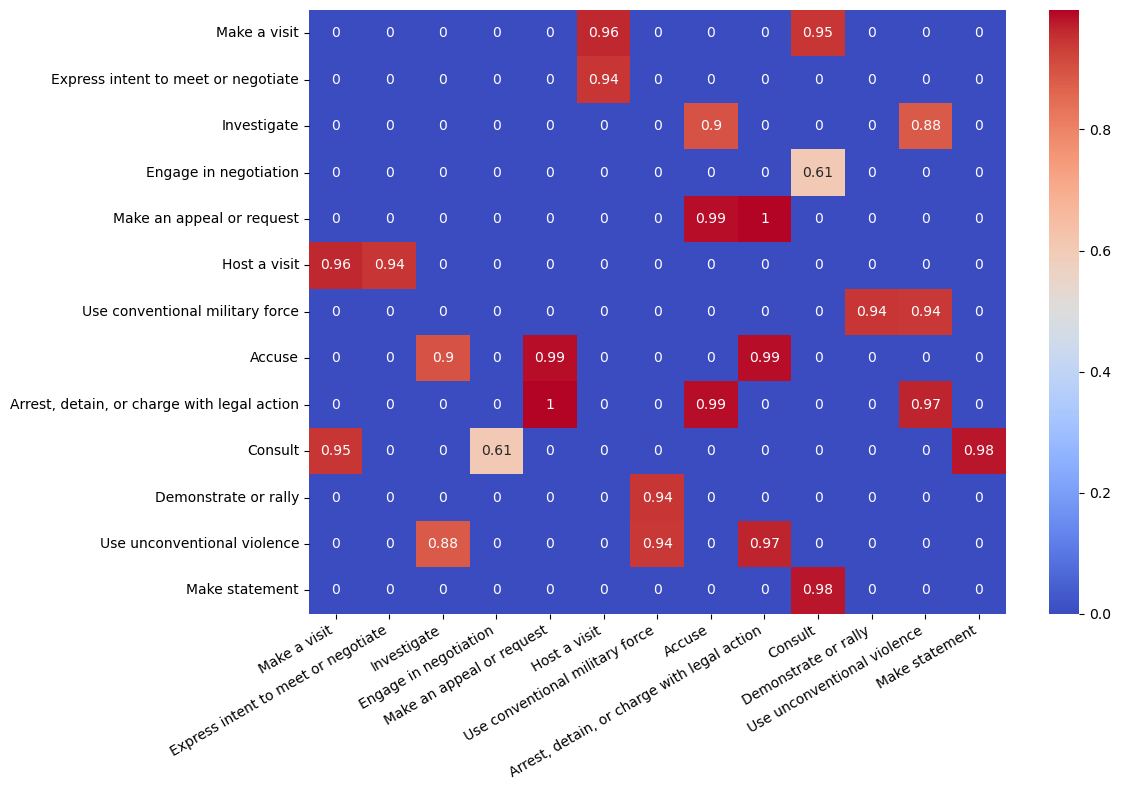

In [23]:
# Step 4: Create the heatmap using seaborn
plt.figure(figsize=(12, 8))  # Adjusted the figure size for longer event names
sns.heatmap(matrix, annot=True, cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=True)
plt.xticks(rotation=30, ha="right")  # Rotate x-axis labels for better fit
plt.yticks(rotation=0)               # Keep y-axis labels horizontal

# Step 6: Add title and display the heatmap
# plt.title("Event Co-occurrence Heatmap", fontsize=16)
plt.tight_layout()  # Adjusts the layout to ensure labels fit well
plt.show()

In [27]:
# # Step 5: Show the heatmap
# plt.title("Event Co-occurrence Heatmap")
# plt.show()

In [88]:
def get_last_n_days_relations(query, day,n):
    query_inv = tuple([query[1], query[0]])
    triples = []
    for key, value in rel_in_dates_w_entities.items():
        if key in range(day-n, day+n):
            for relation, entites in value.items():
                for entity in entites:
                    # print(query, entity[:2])
                    if query == entity[:2]:
                        triples.append([query[0], relation, query[1], key, entity[2]])
                    if query_inv == entity[:2]:
                        triples.append([query_inv[0], relation, query_inv[1], key,entity[2]])
    return triples

In [89]:
def get_last_ten_days_triples(query,day,n):
    triples = []
    for key, value in rel_in_dates_w_entities.items():
        if key in range(day-n, day+n):
            for relation, entites in value.items():
                for entity_pairs in entites:
                    if query[0] in entity_pairs[:2] or query[1] in entity_pairs[:2]:
                        triples.append([entity_pairs[0],relation,entity_pairs[1], key, entity_pairs[2]])
    return triples

In [26]:
graph_quadruple = []

In [27]:
query = (1,31)
day= 18
triples = get_last_n_days_relations(query, day,n=10)
for triple in triples:
    # if triple[1] == 13 or triple[1]==17 or triple[1]==12 or triple[1]==0 or triple[1]==8 or triple[1]==9 or triple[1]==21 or triple[1]==40 or triple[1]==19 or triple[1]==29:
    graph_quadruple.append(tuple([entity_map[triple[0]],relation_map[triple[1]],entity_map[triple[2]],date_map[triple[3]]]))
    print(entity_map[triple[0]],"||",triple[1],relation_map[triple[1]],"||",entity_map[triple[2]],"||",date_map[triple[3]],"||",triple[4])

India || 12 Praise or endorse || Pakistan || 2010-01-09 || Emphasising that India supported a stable Pakistan at peace with itself and the region, External Affairs Minister S M Krishna said, 'We wish to address our differences with Pakistan through dialogue' but a meaningful dialogue will be possible only in an environment free of terrorism'.
India || 12 Praise or endorse || Pakistan || 2010-01-09 || Emphasising that India supported a stable Pakistan at peace with itself and the region, Indian External Affairs Minister S M Krishna said, 'We wish to address our differences with Pakistan through dialogue' but a meaningful dialogue will be possible only in an environment free of terrorism.
Pakistan || 11 Use conventional military force || India || 2010-01-09 || 'Pakistan's failure to shut down the Lashkar-e-Taiba (LeT) more than one year after its attacks in Mumbai-and with knowledge that the group is planning to conduct similar attacks-leads to the conclusion that Pakistan seeks to provo

In [28]:
triples = get_last_ten_days_triples(query, day,n=10)
for triple in triples:
    # if triple[1] == 13 or triple[1]==17 or triple[1]==12 or triple[1]==0 or triple[1]==8 or triple[1]==9 or triple[1]==21 or triple[1]==40 or triple[1]==19 or triple[1]==29:
    graph_quadruple.append(tuple([entity_map[triple[0]],relation_map[triple[1]],entity_map[triple[2]],date_map[triple[3]]]))
    print(entity_map[triple[0]],"||",triple[1],relation_map[triple[1]],"||",entity_map[triple[2]],"||",date_map[triple[3]],"||",triple[4])

India || 1 Arrest, detain, or charge with legal action || Armed Rebel (India) || 2010-01-09 || Sources said the rebel was arrested in Hyderabad city two days ago but the police had kept the news under wraps till this evening.
Military (India) || 14 Investigate || India || 2010-01-09 || Hours after the encounter ended, soldiers were still searching the area for leftover explosives.
A.K. Antony || 0 Make statement || India || 2010-01-09 || On reports that over 700 terrorists were waiting across the border in Pakistan-occupied-Kashmir (PoK) to sneak into J&amp;K, he said India has taken all precautions to deal with the situation.
Ministry (India) || 0 Make statement || Pakistan || 2010-01-09 || The Indian minister said after the Mumbai attacks, Pakistan has taken some 'halting measures to address the evidence presented to them.
Ministry (India) || 0 Make statement || Pakistan || 2010-01-09 || The Indian Minister said after the Mumbai attacks, Pakistan has taken some 'halting measures to a

In [29]:
graph_quadruple = [("India","Arrest, detain, or charge with legal action","Armed Rebel (India)","2010-01-09"),
                   ("Military (India)","Investigate","India","2010-01-09"),
                   ("Pakistan","Reject","India","2010-01-18"),
                  #  ("India" , "Engage in negotiation" , "Pakistan" , "2010-01-18"),
                   ("India" , "Reduce relations","Pakistan", "2010-01-18"),
                   ("A.K. Antony (India)","Make statement","India","2010-01-09"),
                   ("Ministry (India)","Make statement","Pakistan","2010-01-09"),
                #    ("India","Praise or Endorse","Pakistan","2010-01-09")
                   ]

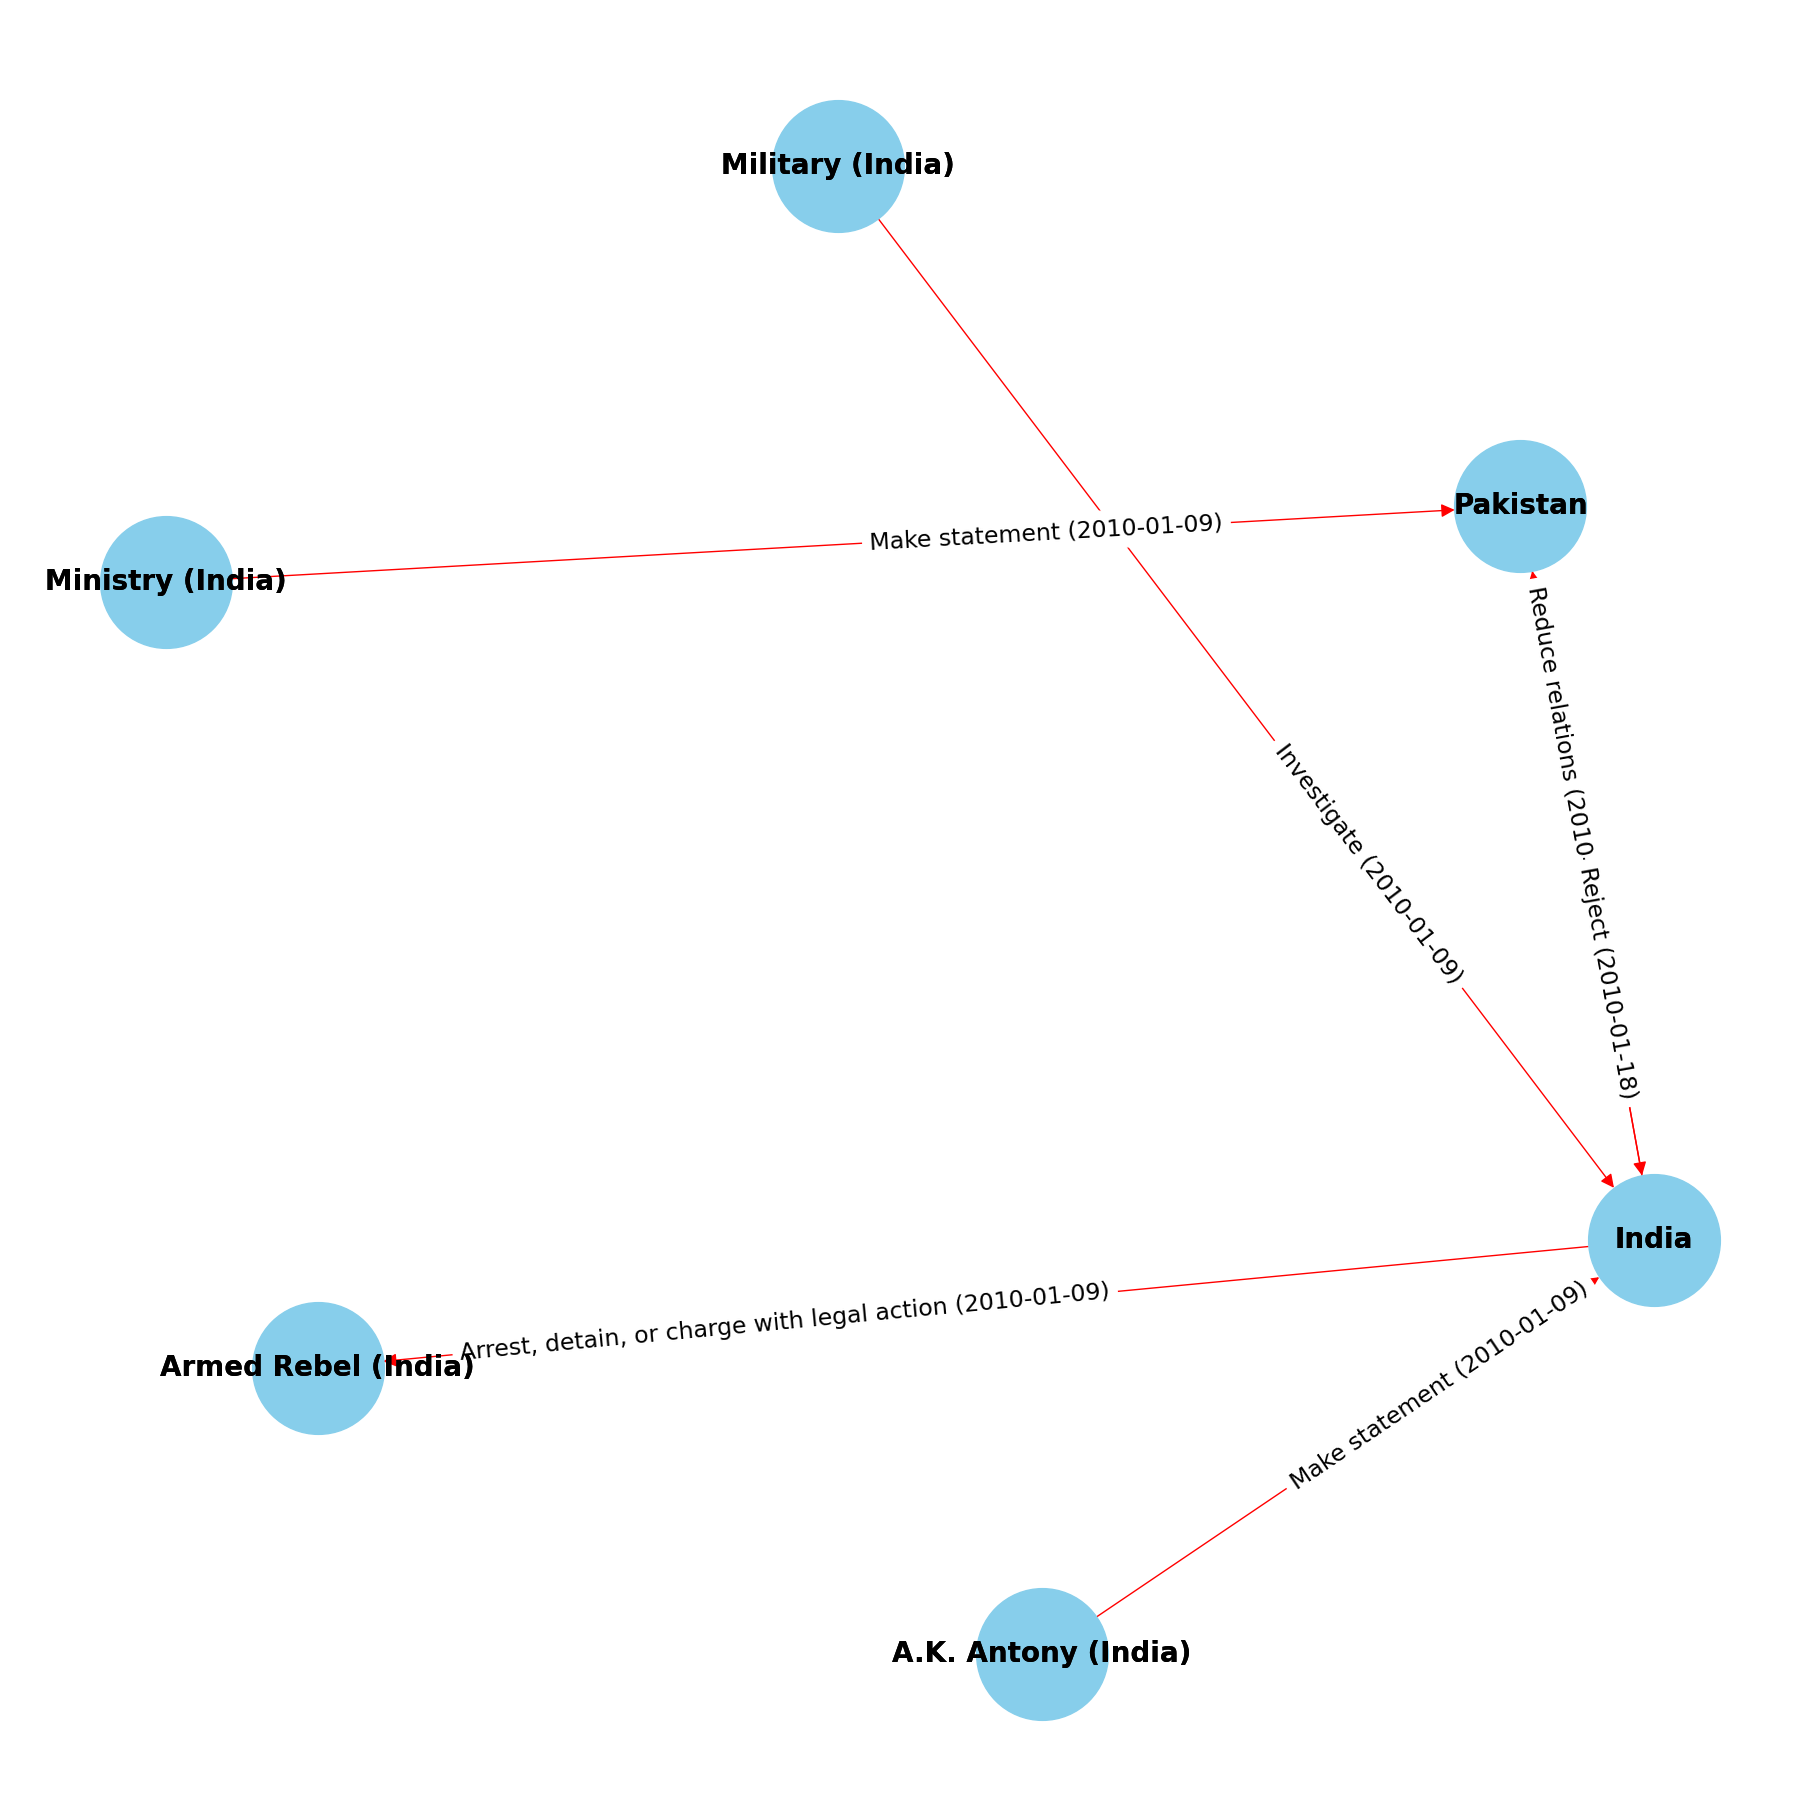

In [30]:
G = nx.DiGraph()

# Add edges to the graph with relationships and date information
for source, relation, target, date in graph_quadruple:
    G.add_edge(source, target, label=f'{relation} ({date})', relation=relation)

# Draw the graph
plt.figure(figsize=(18,18))

# Position nodes using the spring layout (force-directed algorithm)
pos = nx.spring_layout(G,k=4, scale=2)

# Draw the graph components

nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=9000, font_size=20, font_weight='bold', arrowsize=20, edge_color="red")

# Draw edge labels with the relationship and date information
nx.draw_networkx_labels(G, pos, font_size=20, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black',label_pos=0.35,font_size=17)

# edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=16)

# Show plot
# plt.title('Bidirectional Knowledge Graph')
plt.show()

In [59]:
def get_top_corr_entities(df):
    df_list = {}
    final_list = {}
    entity_corr = defaultdict(dict,{ k:{} for k in sorted((pd.Series(df.src,df.tgt)).unique()) })
    for _ , row in df.iterrows():
        if row.tgt not in entity_corr[row.src].keys():
            entity_corr[row.src][row.tgt] = 0
        entity_corr[row.src][row.tgt]+=1

    for src, tgt_dict in entity_corr.items():
        for tgt, count in tgt_dict.items():
            src_tgt = tuple(set((int(src),int(tgt))))
            df_list[src_tgt] = df_list.get(src_tgt, 0) + count

    src_list = df.src.value_counts().to_dict()
    tgt_list = df.tgt.value_counts().to_dict()


    for pair,count in df_list.items():
        if count>100:
            src_count_0 = src_list.get(pair[0],0)
            src_count_1 = src_list.get(pair[1],0)
            tgt_count_0 = tgt_list.get(pair[0],0)
            tgt_count_1 = tgt_list.get(pair[1],0)

            # print(src_count_0,src_count_1,tgt_count_0,tgt_count_1)
            final_list[pair] = count/(src_count_0+src_count_1+tgt_count_0+tgt_count_1)
  
    
    # df_list = sorted(df_list, key=lambda x: x[2], reverse=True)
    # result = pd.DataFrame(df_list,columns=["src","tgt","corr"])
    return final_list


In [60]:
result = get_top_corr_entities(icews_data)

In [61]:
sorted(result.items(), key=lambda x:x[1], reverse=True)

[((0, 2), 0.201820872763152),
 ((145, 249), 0.15609264853977844),
 ((240, 272), 0.10717372515125324),
 ((272, 293), 0.10245183887915937),
 ((259, 68), 0.06857483601669648),
 ((5170, 14), 0.06511135652494018),
 ((27, 28), 0.062086092715231786),
 ((16, 5170), 0.060500761614623),
 ((27, 15), 0.05870771433685341),
 ((17, 5170), 0.05387523629489603),
 ((0, 42), 0.051224741139442594),
 ((41, 44), 0.049949326769943535),
 ((1, 2), 0.04955431539848245),
 ((8, 3), 0.049477838331230366),
 ((0, 13), 0.045503349749323393),
 ((118, 87), 0.04461371055495103),
 ((1, 18), 0.04259780603824871),
 ((153, 35), 0.042313470205307964),
 ((2, 5170), 0.04231026568918753),
 ((9, 5), 0.04132123140263872),
 ((9, 6), 0.0397073573662163),
 ((0, 53), 0.03966307215254316),
 ((9, 2), 0.037899667535934545),
 ((16, 28), 0.037774070543374644),
 ((5170, 20), 0.0336199818503954),
 ((1, 31), 0.033194900241047834),
 ((9, 7), 0.031052601627558473),
 ((8, 4), 0.02580537750769999),
 ((10, 62), 0.024748790472646075),
 ((89, 45), 

In [62]:
final = []
for pair, corr in sorted(result.items(), key=lambda x:x[1], reverse=True): 
    final.append((entity_map[pair[0]],entity_map[pair[1]],corr))

In [63]:
final

[('Police (India)', 'Citizen (India)', 0.201820872763152),
 ('Police (Bangladesh)', 'Citizen (Bangladesh)', 0.15609264853977844),
 ('Naval (Sri Lanka)', 'Fishermen (India)', 0.10717372515125324),
 ('Fishermen (India)', 'Marine Corp (Italy)', 0.10245183887915937),
 ('Pakistan Ranger', 'Border Security Force', 0.06857483601669648),
 ('Unspecified Actor', 'Activist (India)', 0.06511135652494018),
 ('Militant (India)',
  'Military Personnel - Special (India)',
  0.062086092715231786),
 ('Protester (India)', 'Unspecified Actor', 0.060500761614623),
 ('Militant (India)', 'Military (India)', 0.05870771433685341),
 ('Student (India)', 'Unspecified Actor', 0.05387523629489603),
 ('Police (India)', 'Men (India)', 0.051224741139442594),
 ('Education (India)', 'Education Ministry (India)', 0.049949326769943535),
 ('India', 'Citizen (India)', 0.04955431539848245),
 ('Congress (India)', 'Bharatiya Janata', 0.049477838331230366),
 ('Police (India)', 'Criminal (India)', 0.045503349749323393),
 ('Musli

In [46]:
len(final)

41688

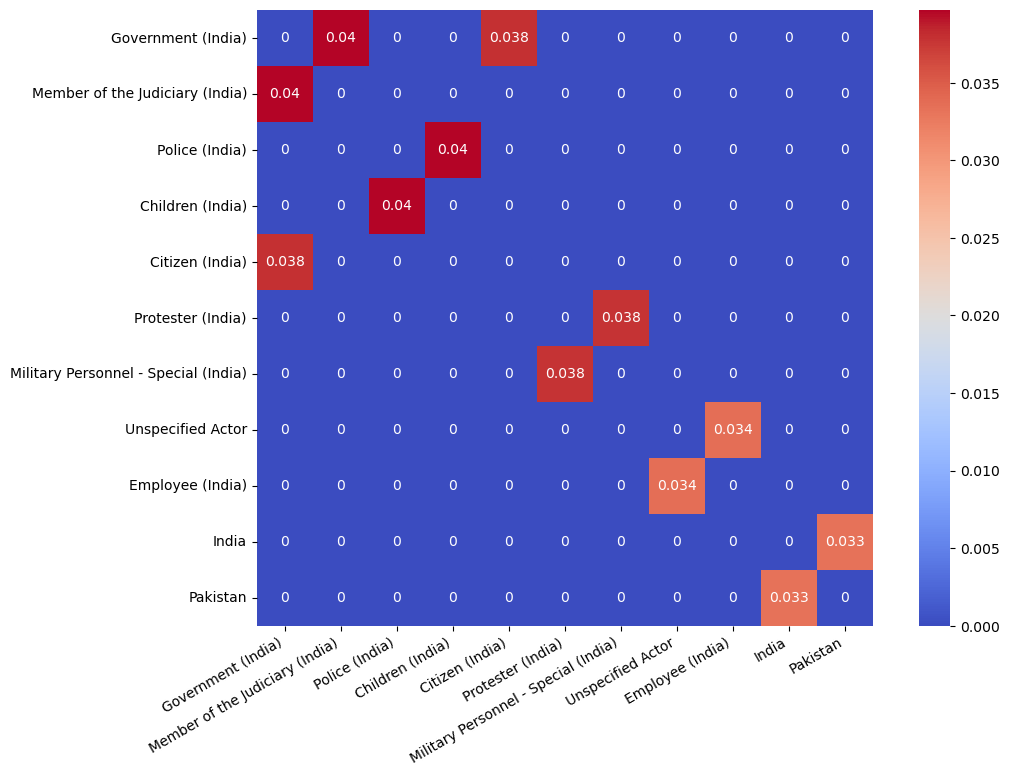

In [121]:
df = pd.DataFrame(final[20:26], columns=['Entity1', 'Entity2', 'corr_ratio'])

# Get all unique entities from both columns
unique_entities = pd.unique(df[['Entity1', 'Entity2']].values.ravel())

# Create an empty DataFrame with all unique entities as both row and column labels
heatmap_data = pd.DataFrame(index=unique_entities, columns=unique_entities, data=0)

# Fill the DataFrame with the correlation ratios from the original data
for _, row in df.iterrows():
    heatmap_data.loc[row['Entity1'], row['Entity2']] = row['corr_ratio']
    heatmap_data.loc[row['Entity2'], row['Entity1']] = row['corr_ratio']  # Ensure symmetry

# Plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", cbar=True, square=True)
# plt.title("Complete Correlation Heatmap between Entities")
plt.xticks(rotation=30, ha="right")  # Rotate x-axis labels for better fit
plt.yticks(rotation=0) 
plt.show()

In [78]:
for key, value in date_map.items():
    if value=="2016-01-01":
        print(key)

2191


In [111]:
query = (1,31)
day= 2191
graph_quadruple=[]
triples = get_last_n_days_relations(query, day,n=5)
for triple in triples:
    # if triple[1] == 13 or triple[1]==17 or triple[1]==12 or triple[1]==0 or triple[1]==8 or triple[1]==9 or triple[1]==21 or triple[1]==40 or triple[1]==19 or triple[1]==29:
    graph_quadruple.append(tuple([entity_map[triple[0]],relation_map[triple[1]],entity_map[triple[2]],date_map[triple[3]],triple[4]]))
    print(entity_map[triple[0]],"||",relation_map[triple[1]],"||",entity_map[triple[2]],"||",date_map[triple[3]],"||",triple[4])

India || Consult || Pakistan || 2015-12-27 || New Delhi: Of what significance would a meeting of Indian and Pakistani prime ministers be that did not discuss Kashmir, Hurriyat or cricket?
India || Engage in negotiation || Pakistan || 2015-12-27 || Sindhi newspapers also prominently reported that Pakistan and India decided to start foreign secretaries talks in January 2016 , Indian Prime Minister Narendra Modi visited Pakistan for few hours and held meeting with Pakistani Prime Minister Nawaz Sharif, congratulated PM Sharif on his birthday, both leaders announced to continue peace process and take it further; Asif Ali Zardari on his message on 8th death anniversary of [former Prime Minister] Benazir Bhutto said that federal government attacked Sindh in the garb of law and order situation, he said his party would not allow trampling of constitution; the Sindh government announced to send murder case of Khalid Mehmud Soomro, general secretary of the Jamiat Ulema-e-Islam-Fazlur Rahman grou

In [112]:
triples = get_last_ten_days_triples(query, day,n=5)
for triple in triples:
    # if triple[1] == 13 or triple[1]==17 or triple[1]==12 or triple[1]==0 or triple[1]==8 or triple[1]==9 or triple[1]==21 or triple[1]==40 or triple[1]==19 or triple[1]==29:
    graph_quadruple.append(tuple([entity_map[triple[0]],relation_map[triple[1]],entity_map[triple[2]],date_map[triple[3]],triple[4]]))
    print(entity_map[triple[0]],"||",relation_map[triple[1]],"||",entity_map[triple[2]],"||",date_map[triple[3]],"||",triple[4])

Cabinet / Council of Ministers / Advisors (India) || Accuse || India || 2015-12-27 || Participating in the CPI’s 90th foundation day celebrations in Karimnagar town on Sunday, he charged the government of not taking up any drought relief measures to provide some succour to the distressed farming community.
India || Accuse || Villager (India) || 2015-12-27 || KORAPUT: The Maoists allegedly killed two villagers, including a sarpanch, in Malkangiri district late on Friday accusing them of acting as police informers.
Maldives || Make an appeal or request || India || 2015-12-27 || 'Maldives, Nepal, Bangladesh and Bhutan have already requested India to provide specialized training to their personnel and help in raising a specialized force like the NDRF,' said Santosh Kumar, director of the National Institute of Disaster Management in the home ministry.
Bhutan || Make an appeal or request || India || 2015-12-27 || 'Maldives, Nepal, Bangladesh and Bhutan have already requested India to provide

In [115]:
data = pd.DataFrame(graph_quadruple,columns=["src","rel","tgt","time","text"])
data.to_csv(path_or_buf="D:\\personal-Shreyas\\AIRS\\notebooks and src\\corr.csv")